In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:85% !important;}</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

from sklearn.datasets import make_classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
import tboost

In [3]:
import targen

In [4]:
tboost.__path__

['/Users/sandro/Analytics/Packages/TransferBoost/tboost']

In [5]:
from helpers import gen_samples, setup_logging, shift_features, psi

setup_logging()

In [6]:
data_raw = gen_samples(n_samples = 20, n_exp = 2, n_unif =1, n_normal = 1)
data_raw = data_raw.reset_index().rename(columns={"index":"time_col"})

2021-03-01 16:19:56 - INFO - gen_samples: Generating 2 exponential features with 20 rows
2021-03-01 16:19:56 - INFO - gen_samples: Generating 1 uniform features with 20 rows
2021-03-01 16:19:56 - INFO - gen_samples: Generating 1 normal features with 20 rows


In [7]:
make_copy = lambda x: x.copy()

data = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data_raw.columns, min_max_scaler_range=(1,100))
)

features = [col for col in data_raw.columns if col.startswith("col_")]

In [8]:
features

['col_exp_0', 'col_exp_1', 'col_uni_0', 'col_norm_0']

# Add targets

In [9]:
from targen.data import target

In [10]:
interaction_terms_1 = "".join([
    "2.5*col_exp_0*col_exp_1",
    "-0.2*col_uni_0*col_exp_1",
    "+0.7*col_norm_0*col_exp_1",
    
    "+0.8*col_norm_0*col_uni_0", #
    "-1.3*col_uni_0/col_exp_1", # the shift shoul reduce here the effect  
])

expressions_1 = {
    'linear': '-0.5*col_exp_0 + 2*col_uni_0 -3.2*col_norm_0',
    
    'interaction': interaction_terms_1,
    
    'uniform_noise': {
        'weight':7.7
    },
    'gaussian_noise': {
        'weight':12.4,
        'mu_gaus': -1.5
    }
}

In [11]:
data_y_1 = target.get_target_and_contributions(data, expressions=expressions_1, imbalance = 0.4, 
                                             drop_features=False)

In [12]:
X, y = data_y_1[features],data_y_1['y']

In [13]:
! pip install xgboost

1
[16:19:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81771	validation_0-logloss:0.55632
[9]	validation_0-auc:0.98958	validation_0-logloss:0.27337


/Users/sandro/.miniconda/installation/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


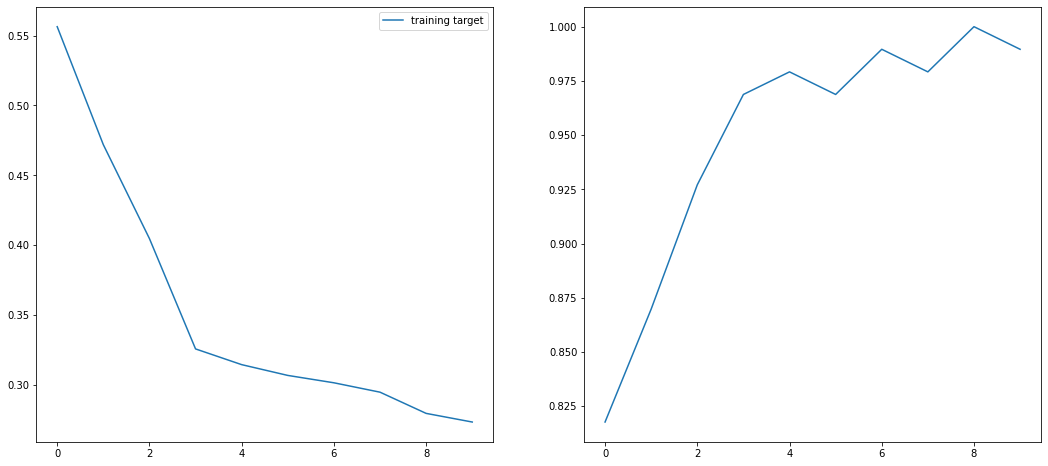

In [14]:
import xgboost as xgb

min_frac =int(0.05*X.shape[0])
print(min_frac)

model = xgb.XGBClassifier(
    max_depth = 2,
    reg_lambda = 0,
    num_leaves=4,
    n_estimators=10,
    min_child_samples=min_frac,
    learning_rate=0.5
)

eval_set = [(X,y)]
model.fit(
    X,
    y,
    eval_metric=["auc","logloss"], 
#     eval_names = ['validation_0','validation_1'],
    eval_set=eval_set, 
    verbose=30, # after how many training sets you want the printout on the console
    early_stopping_rounds=39
)

fig, ax = plt.subplots(1,2,figsize=(18,8))


ax[0].plot(model.evals_result_['validation_0']['logloss'], label = "training target")
# ax[0].plot(model.evals_result_['validation_1']['logloss'], label = "test target")

ax[1].plot(model.evals_result_['validation_0']['auc'])
# ax[1].plot(model.evals_result_['validation_1']['auc'])
ax[0].legend()

In [15]:
from tboost.utils.boost import recompute_leaves

In [16]:
stop here

SyntaxError: invalid syntax (<ipython-input-16-a96ba3aab008>, line 1)

In [21]:
X_leafs = model.apply(X)
model_params = model.get_params()
display(X_leafs)


array([[4, 3, 2, 3, 2, 2, 1, 4, 2, 2],
       [2, 4, 4, 2, 1, 1, 2, 2, 4, 1],
       [2, 1, 2, 2, 2, 1, 2, 2, 2, 2],
       [3, 3, 4, 3, 1, 1, 1, 3, 3, 1],
       [3, 3, 4, 3, 1, 1, 1, 4, 3, 1],
       [2, 4, 2, 2, 2, 1, 2, 2, 4, 2],
       [4, 1, 3, 3, 1, 2, 1, 3, 3, 1],
       [4, 1, 3, 4, 1, 2, 2, 3, 4, 1],
       [3, 4, 2, 4, 2, 1, 2, 4, 2, 2],
       [4, 1, 3, 3, 1, 2, 1, 3, 3, 1],
       [2, 3, 3, 2, 1, 2, 2, 2, 4, 1],
       [3, 4, 2, 3, 2, 1, 1, 4, 3, 2],
       [3, 3, 4, 3, 1, 1, 1, 3, 3, 1],
       [3, 3, 4, 3, 1, 1, 1, 3, 4, 1],
       [3, 3, 3, 3, 1, 1, 1, 3, 3, 1],
       [2, 1, 2, 2, 2, 1, 2, 2, 2, 2],
       [3, 4, 2, 4, 2, 1, 2, 2, 2, 2],
       [3, 3, 2, 4, 2, 1, 2, 4, 2, 2],
       [4, 4, 2, 3, 2, 2, 1, 4, 2, 2],
       [4, 3, 4, 4, 1, 2, 2, 3, 4, 1]], dtype=int32)

In [22]:

X_leaf_outputs = recompute_leaves(X_leafs, X, y, model_params=model_params)

start leaf = 0.0


/Users/sandro/Analytics/Packages/TransferBoost/tboost/utils/boost.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  -learning_rate * grad[leaves == leave_ix].sum() / (hess[leaves == leave_ix].sum() + reg_lambda)
/Users/sandro/Analytics/Packages/TransferBoost/tboost/utils/loss_functions.py:47: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(x)/(1.0 + np.exp(x))


array([2, 3, 4], dtype=int32)

array([-0.74170229,  0.09754784,  1.10370154])

<AxesSubplot:>

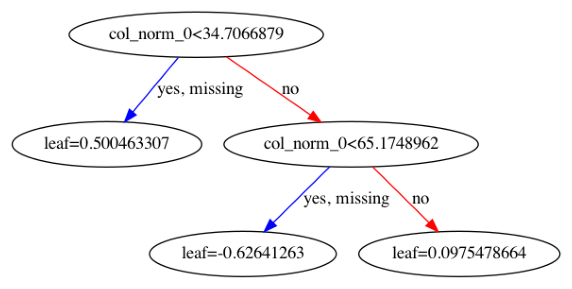

In [25]:
tree_index = 1

display(np.unique(X_leafs[:,tree_index+1]))
display(np.unique(X_leaf_outputs[:,tree_index+1]))

fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = tree_index)

In [ ]:
X.shape

In [ ]:
model_params

In [ ]:
from tboost.utils.loss_functions import _sigmoid, _logistic

In [ ]:
model.predict_proba(X, ntree_limit=3)[:,1]

In [ ]:
_logistic(X_leaf_outputs[:,:4].sum(axis=1))

In [ ]:
# Check why the the 

In [ ]:
X_leaf_outputs[:,1]

In [ ]:
np.unique(X_leaf_outputs[:,1])

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = 3)

In [ ]:
from functools import reduce

def plot_proba_evol(X,y,model, max_n_trees=500):
    arrays = list()
    for ix in range(1,max_n_trees+1):
        try:
            pred_ix = model.predict_proba(X, num_iteration=ix)[:,1]
        except:
            pred_ix = model.predict_proba(X, ntree_limit=ix)[:,1]
        arrays.append(pred_ix)
    return np.transpose(reduce(lambda x,y: np.vstack((x,y)),arrays))        
        
    
def find_pred_trend(X,y,model, max_n_trees = 500):
    
    proba_trees = plot_proba_evol(X,y,model, max_n_trees=max_n_trees)
    
#     return proba_trees
    
    mean_y_0 = proba_trees[y.values==0].mean(axis=0)
    std_y_0 = proba_trees[y.values==0].std(axis=0)

    mean_y_1 = proba_trees[y.values==1].mean(axis=0)
    std_y_1 = proba_trees[y.values==1].std(axis=0)
    
    return mean_y_0, std_y_0, mean_y_1, std_y_1

In [ ]:
y.value_counts()

In [ ]:
mean_y_zero_train_1, std_y_zero_train_1, mean_y_one_train_1, std_y_one_train_1 = find_pred_trend(X,y,model,max_n_trees=10)
mean_y_zero_1, std_y_zero_1, mean_y_one_1, std_y_one_1 = find_pred_trend(X,y,model,max_n_trees=10)


x = [i for i in range(1, mean_y_zero_train_1.shape[0]+1)]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(x,mean_y_zero_train_1, label = "y=0 train", color='orange', linestyle='--')
ax.fill_between(x, mean_y_zero_train_1-std_y_zero_train_1, mean_y_zero_train_1+std_y_zero_train_1, color='orange',alpha=0.2)

ax.plot(x,mean_y_one_train_1, label = "y=1 train", color='blue',linestyle='--')
ax.fill_between(x, mean_y_one_train_1-std_y_one_train_1, mean_y_one_train_1+std_y_zero_train_1, color='blue',alpha=0.2)
ax.plot(x,mean_y_zero_1, label = "y=0", color='orange')
ax.plot(x,mean_y_one_1, label = "y=1", color='blue')


ax.legend()

# ax[1].plot(std_y_zero_train_1, label = "y=0 train", color='orange', linestyle='--')
# ax[1].plot(std_y_one_train_1, label = "y=1 train", color='blue',linestyle='--')
# ax[1].plot(std_y_zero_1, label = "y=0", color='orange')
# ax[1].plot(std_y_one_1, label = "y=1", color='blue')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = 0)

In [ ]:
Stop here

In [ ]:
model.learning_rate

In [ ]:
tree_index = 0
reg_lambda = 0
leaf_outs = {}
leaves = l[:,tree_index]
for leave_ix in np.unique(leaves):
    leaf_outs[leave_ix] = 0.3*g[leaves==leave_ix].sum()/(h[leaves==leave_ix].sum() + reg_lambda)
    
leaf_outs

In [ ]:
g[leaves==4].sum()